# Propositional Logic
Syntax and Semantics Explained using a Prolog Implementation

## Well-Formed Formulas (WFF)

All atomic propositions are WFF)
If a und b are WFF then so are:
- (¬ a)
- (a ∧ b)
- (a ∨ b)
- (a ⇒ b)
- (a ⟺ b)
No other formulas are WFF.

Comment: a, b are metavariablens outside the syntax of propositional logic.


Maybe this reminds you of formal grammars from a theoretical computer science lecture.
And indeed, the above can be written as a grammar using a non-terminal symbol wff.

In Prolog, grammars can actually be written using DCG notation, which we will see and understand much later in the course.
Here we simply write the grammar in Prolog style and can then use it to check if a formula is a WFF:

In [11]:
 :- set_prolog_flag(double_quotes, codes).
wff --> "p". % atomic proposition
wff --> "q". % atomic proposition
wff --> "(¬",wff,")".
wff --> "(", wff, "∧", wff, ")".
wff --> "(", wff, "∨", wff, ")".
wff --> "(", wff, "⇒", wff, ")".
wff --> "(", wff, "⟺", wff, ")".

% The Prolog server was restarted

In [12]:
?- wff("p","").

true

In [13]:
?- wff("(¬p)","").

true

In [14]:
?- wff("(p∧(q∨(¬p)))","").
%comment.

true

This grammar does not talk about whitespace and requires parentheses for every connective used.
In practice, one typically uses operator precedences to avoid having to write too many parentheses:
- negation binds strongest
- then come conjunction and disjunction
- then come implication and equivalence.

So instead of
- (((¬ p) ∧ (¬ q)) ⇒ ((¬ p) ∨ (¬ q)))
we can write
- ¬ p ∧ ¬ q ⇒ ¬ p ∨ ¬ q

We will try not not mix conjunction/disjunction and implication/equivalence without parentheses.
We will also not try to improve our Prolog parser here to accomodate these precedences.
This is the subject of another course (on compiler construction).

We will also see much later that Prolog allows one to annotate grammars with semantic values, here to generate
a Prolog term representing the logical formal in the form of a syntax tree:

In [15]:
 :- set_prolog_flag(double_quotes, codes).
wff(p) --> "p". % atomic proposition
wff(q) --> "q". % atomic proposition
wff(not(A)) --> "(¬",wff(A),")".
wff(and(A,B)) --> "(", wff(A), "∧", wff(B), ")".
wff(or(A,B)) --> "(", wff(A), "∨", wff(B), ")".
wff(impl(A,B)) --> "(", wff(A), "⇒", wff(B), ")".
wff(equiv(A,B)) --> "(", wff(A), "⟺", wff(B), ")".

In [16]:
?- wff(Formula,"(¬p)","").

Formula = not(p)

In [17]:
?- wff(Formula,"(¬(p∧q))","").

Formula = not(and(p,q))

In [18]:
?- wff(Formula,"(p∧(q∨(¬p)))","").

Formula = and(p,or(q,not(p)))

The above Prolog term `and(p,or(q,not(p)))` represents the logical formula in tree form.
We can display the tree as a dag (directed acyclic graph) using the following subsidiary code
(in future the Jupyter kernel will probably have a dedicated command to show a term graphically):

In [19]:
subtree(Term,Nr,SubTerm) :- 
   Term =.. [_|ArgList], %obtain arguments of the term
   nth1(Nr,ArgList,SubTerm). % get sub-argument and its position number

% recursive and transitive closure of subtree
rec_subtree(Term,Sub) :- Term = Sub.
rec_subtree(Term,Sub) :- subtree(Term,_,X), rec_subtree(X,Sub).

subnode(Sub,[shape/S, label/F],Formula) :- 
   rec_subtree(Formula,Sub), % any sub-formula Sub of Formula is a node in the graphical rendering
   functor(Sub,F,_), (atom(Sub) -> S=egg ; number(Sub) -> S=oval ; S=rect).

In [20]:
jupyter:print_table(subnode(Node,Dot,and(p,or(q,not(p)))))

Node | Dot | 
:- | :- | 
and(p,or(q,not(p))) | [shape/rect,label/and] | 
p | [shape/egg,label/p] | 
or(q,not(p)) | [shape/rect,label/or] | 
q | [shape/egg,label/q] | 
not(p) | [shape/rect,label/not] | 
p | [shape/egg,label/p] | 

true

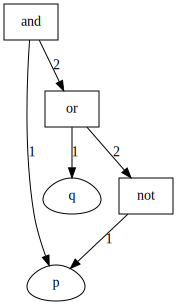

true

In [21]:
jupyter:show_graph(subnode(_,_,and(p,or(q,not(p)))),subtree/3)

Below we will study how one can assign a truth-value to logical formulas like the one above.

## Truth tables

Every logical connective has a truth-table, indicating how it maps the truth of its arguments to its own truth value.
For example, `and` maps inputs `true` and `false` to `false`.

In [22]:
not(true,false).
not(false,true).

and(true,V,V) :- truth_value(V).
and(false,_,false).

or(true,_,true).
or(false,V,V) :- truth_value(V).

implies(A,B,Res) :- not(A,NotA), or(NotA,B,Res).
equiv(A,B,Res) :- implies(A,B,AiB), implies(B,A,BiA), and(AiB,BiA,Res).

truth_value(true).
truth_value(false).

truth_table(A,B,NotA,AandB,AorB,AiB,AeB) :- 
   truth_value(A), truth_value(B),
   not(A,NotA), and(A,B,AandB), or(A,B,AorB),
   implies(A,B,AiB), equiv(A,B,AeB).

In [23]:
jupyter:print_table(truth_table(A,B,NotA,AandB,AorB,AimpliesB,AequivB))

A | B | NotA | AandB | AorB | AimpliesB | AequivB | 
:- | :- | :- | :- | :- | :- | :- | 
true | true | false | true | true | true | true | 
true | false | false | false | true | false | false | 
false | true | true | false | true | true | false | 
false | false | true | false | false | true | true | 

true

In [24]:
value(X,Interpretation,Value) :- 
   atomic(X), % we could also use: proposition(X),
   member(X/Value,Interpretation).
value(and(A,B),I,Val) :- value(A,I,VA), value(B,I,VB),
   and(VA,VB,Val).
value(or(A,B),I,Val) :- value(A,I,VA), value(B,I,VB),
   or(VA,VB,Val).
value(not(A),I,Val) :- value(A,I,VA),
   not(VA,Val).
value(implies(A,B),I,Val) :- value(or(not(A),B),I,Val).
value(equiv(A,B),I,Val) :- 
   value(and(implies(A,B),implies(B,A)),I,Val).


In [25]:
?- value(and(p,or(q,not(p))), [p/true, q/false],Res).

Res = false

In [26]:
jupyter:print_table(value(and(p,or(q,not(p))), [p/P, q/Q],Res))

P | Q | Res | 
:- | :- | :- | 
true | true | true | 
true | false | false | 
false | true | false | 
false | false | false | 

true

In [27]:

subnode_val(Sub,[shape/S, label/F, style/filled, fillcolor/C],Formula,Interpretation) :- 
   rec_subtree(Formula,Sub), % any sub-formula Sub of Formula is a node in the graphical rendering
   functor(Sub,F,_), (atom(Sub) -> S=egg ; number(Sub) -> S=oval ; S=rect),
   (value(Sub,Interpretation,true) -> C=olive ; C=sienna1).

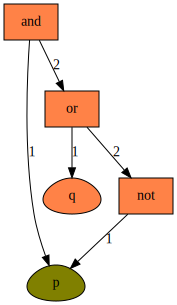

true

In [28]:
jupyter:show_graph(subnode_val(_,_,and(p,or(q,not(p))),[p/true,q/false]),subtree/3)

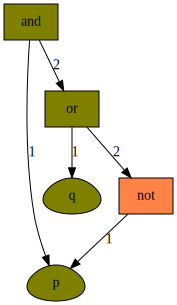

true

In [29]:
jupyter:show_graph(subnode_val(_,_,and(p,or(q,not(p))),[p/true,q/true]),subtree/3)

In [30]:
?- use_module(library(clpfd)).

true